# PSF Photometry using effective PSF models (in python!)

We present a software stack for fitting the PSF models developed by J Anderson for HST/WFC3 to perform high precision PSF photometry.  In general, the process is as follows:
1. Find and fit stars in each image using the PSF model
2. Align the images using the PSF fitted catalogs
3. Match the stars and collate/average the measurements into one final catalog.
In this notebook, we show a simple workflow for performing these tasks using the psf_tools package.



### Versions!

NOTE: These tools require an installation of astroconda, using python 3.6, and photutils >= 0.7.1.  It also requires astroquery and skimage >=0.15.0

# Table of Contents
0. [Data Download](#dl)

1a. [Fortran Interface](#fortran)

1b. [Python Interface](#python)
2. [Align Images](#align)
3. [Collate/Average Measurements](#average)
4. [Results](#results)

In [1]:
# some parameters we will use consistently
hmin = 5
fmin = 1000.
pmax= 66000.

In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

from astropy.io import fits
from astropy.table import Table
from astroquery.mast import Observations

from psf_tools import run_hst1pass, run_python_psf_fitting, align_images, make_final_table, \
                    match_final_catalogs, match_to_master_catalog

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [47]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 10
plt.rcParams.update({'axes.titlesize' : '18',
                     'axes.labelsize' : '14',
                     'xtick.labelsize' : '14',
                     'ytick.labelsize' : '14'})
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
%matplotlib inline

# 0. First, download some data
<a id="dl">

Let's download some data from the outer regions of Omega Cen to start.  We will use images in 2 filters, 2 epochs each.

In [6]:
cd oc/

/Users/vbajaj/Documents/wfc3_photometry/wfc3_photometry/oc


In [7]:
obsTable = Observations.query_criteria(project='HST',proposal_id='14118', obs_id='ICTJ4[5678]*', obstype='all')
products = Observations.get_product_list(obsTable)
filtered_products = Observations.filter_products(products,mrp_only=False, productSubGroupDescription='FLC')
dl_tbl = Observations.download_products(filtered_products,mrp_only=False)
files = []
for f in dl_tbl['Local Path']:
    filename = os.path.split(f)[-1]
    files.append(filename)
    if not os.path.exists(filename):
        shutil.move(f, '.')


### Multiple filters in downloaded data, only look at/fit one band at a time

In [8]:
input_images =[im for im in  sorted(files) if fits.getval(im, 'FILTER')== 'F814W']

### Lets fit just the longer exposures in this example

In [9]:
input_images = [im for im in input_images if fits.getval(im, 'EXPTIME') > 200.]

In [10]:
for im in input_images:
    print(im, fits.getval(im, 'exptime'), fits.getval(im, 'date-obs'), fits.getval(im, 'filter'))

ictj45ajq_flc.fits 1253.0 2016-06-27 F814W
ictj45b9q_flc.fits 1345.0 2016-06-27 F814W
ictj46cuq_flc.fits 1253.0 2016-07-04 F814W
ictj46czq_flc.fits 1345.0 2016-07-04 F814W


# 1a. Fortran Interface<a id="fortran"></a>

### See input options:

In [11]:
run_hst1pass?

In general, the default parameters passed are suitable for most use cases.  The only parameters that would be recommeneded to edit would be `fmin`, `pmax`, and `hmin`.  There are also extra keyword arguments that can be passed to the call, but support for those parameters is not guaranteed.

To see other keyword arguments, run the fortran executable with no arguments

In [12]:
import psf_tools
print(psf_tools.PSFPhot._get_exec_path())

/Users/vbajaj/Documents/wfc3_photometry/wfc3_photometry/psf_tools/hst1pass_darwin.e


Replace the path below with whatever was output above

In [ ]:
! /Users/vbajaj/Documents/wfc3_photometry/wfc3_photometry/psf_tools/hst1pass_darwin.e

### Run the PSF photometry

The executable is ran in the following cell using the Fortran engine.  Supplying `focus=-1` parameter tells the software to determine and use the focus dependent PSF library.  If not supplied then the standard (spatially dependent, but non focus dependent PSFs are used.

In [ ]:
catalogs = run_hst1pass(input_images=input_images, hmin=hmin, fmin=fmin, pmax=pmax)

### See the output catalogs

In [13]:
# If you already have the output catalogs, and dont want to rerun hst1pass
catalogs = [im.replace('.fits', '.xympqks') for im in input_images]

In [14]:
catalogs

['ictj45ajq_flc.xympqks',
 'ictj45b9q_flc.xympqks',
 'ictj46cuq_flc.xympqks',
 'ictj46czq_flc.xympqks']

If ran with the flag `focus = -1` (uses focus dependent PSF) focus of image can be output

In [15]:
from psf_tools.PSFPhot import check_focus

In [16]:
check_focus(catalogs)

{'ictj45ajq_flc.xympqks': 0.0,
 'ictj45b9q_flc.xympqks': 0.0,
 'ictj46cuq_flc.xympqks': 0.0,
 'ictj46czq_flc.xympqks': 0.0}

In [17]:
output_catalogs = []
for im in input_images:
    cat_str = im.replace('.fits', '_sci?_xyrd.cat')
    output_catalogs += glob.glob(cat_str)
output_catalogs = sorted(output_catalogs)

##### The hst1pass files are broken up per chip.  The following catalogs should be used for the exposure level analysis

In [18]:
output_catalogs

['ictj45ajq_flc_sci1_xyrd.cat',
 'ictj45ajq_flc_sci2_xyrd.cat',
 'ictj45b9q_flc_sci1_xyrd.cat',
 'ictj45b9q_flc_sci2_xyrd.cat',
 'ictj46cuq_flc_sci1_xyrd.cat',
 'ictj46cuq_flc_sci2_xyrd.cat',
 'ictj46czq_flc_sci1_xyrd.cat',
 'ictj46czq_flc_sci2_xyrd.cat']

# Python interface<a id="python"></a>

A fully python based interface is  available for the PSF fitting.  The python interface has a pared down feature set, and does not yet support the focus based PSFs (coming soon!), and runs slower, but has a more familiar usage compared to the Fortran interface.   The fortran interface can also much more reliably measure UVIS saturated stars, whereas the Python interface cannot. The output `xyrd` catalogs are the same as the fortran, and so either interface can be selected for use for the initial fittings, and then the following alignment/collating steps are the same.

### Look at inputs

In [96]:
run_python_psf_fitting?

In general, the parameters to the python interface are very similar.  More of the keyword arguments are specified directly (qmax, cmin, cmax), and have docstrings specifying their use.  You can also specify the number of CPUs to distribute the fitting across, which subtrantially improves performance when > 1 (default is to use all CPUs).  

### Run the python fitting

In [ ]:
run_python_psf_fitting(input_images, hmin=hmin, fmin=fmin, pmax=pmax)

### Look at one of the xyrd catalogs

The xyrd catalogs contain the outputs from the fitting.  Depending on what was selected in the fitting parameters, the number of columns may vary.  However, the important columns are:

`x`, `y`: The pixel positions of the source measured (1-indexed)

`r`, `d`: The decimal degree RA and Dec of the source measured

`m`: The instrumental magnitude of the fitted PSF (`-2.5 * np.log10(flux [electrons])`)

`q`: The fit quality (see docstring of `run_python_psf_fitting()` for more info)

In [19]:
Table.read(output_catalogs[0], format='ascii.commented_header')

x,y,r,d,m,p,q,s
float64,float64,float64,float64,float64,float64,float64,float64
3456.623,5.508,201.53576780409784,-47.64954250492913,-12.257,10252.03,0.036,60.13
4090.566,4.816,201.52926798659138,-47.65514064330758,-12.915,20793.87,0.085,47.6
126.94,6.09,201.56954309201672,-47.62049103260623,-13.225,31420.77,0.027,68.89
1840.799,5.89,201.5522398747949,-47.635375872342685,-12.019,10582.78,0.04,47.55
3450.881,6.418,201.53581426693097,-47.64948610945756,-12.004,9103.64,0.08,58.42
1430.665,7.361,201.55637680473959,-47.63179181683829,-12.201,10663.25,0.027,40.49
2910.116,7.614,201.54133026715866,-47.644723427944704,-12.912,23246.69,0.037,49.73
3087.673,7.691,201.53951483436,-47.646282370166034,-11.25,4679.92,0.037,37.69
3112.823,8.754,201.5392431643135,-47.64649661835765,-8.235,338.05,0.109,33.94


# 2. Align the images <a id="align"></a>

With the image based catalogs, we can now align them using the accurate positions from the PSF fitting steps.  The alignment not only removes pointing error between images, but also makes the images/catalogs useful for astrometric studies.  This step also corrects the RAs/Decs in the catalogs with the updated values resulting from the alignment.  Furthermore, aligning the images is crucial for tbe final matching/averaging step.

### See options for aligning the images using the catalogs from previous step

In [ ]:
align_images?

Setting `gaia=True` will automatically download and align the catalogs to Gaia DR2 (no proper motions added due to low precision of Gaia proper motions).  This yields high accuracy absolute astrometric measurements!

In [29]:
align_images(input_images, searchrad=.6, gaia=True)


Calculating coordinate ranges for Gaia query:
Query finished.
Sources returned: 3243
Setting up logfile :  tweakreg.log
TweakReg Version 1.4.7(18-April-2018) started at: 10:53:45.65 (27/01/2020) 

Version Information
--------------------
Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
numpy Version -> 1.17.4 
astropy Version -> 3.2.3 
stwcs Version -> 1.5.3 

Finding shifts for: 
    ictj45ajq_flc.fits
    ictj45b9q_flc.fits
    ictj46cuq_flc.fits
    ictj46czq_flc.fits

===  Source finding for image 'ictj45ajq_flc.fits':
     Found 4406 objects.
     Found 4349 objects.
===  FINAL number of objects in image 'ictj45ajq_flc.fits': 8755
Quitting as a result of user request (Ctrl-C)...
Trailer file written to:  tweakreg.log
Updating Catalogs with new RA/Dec


### Can also run with any arguments passed to TweakReg


Calculating coordinate ranges for Gaia query:
Query finished.
Sources returned: 3243
Setting up logfile :  tweakreg.log
TweakReg Version 1.4.7(18-April-2018) started at: 10:53:53.08 (27/01/2020) 

Version Information
--------------------
Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
numpy Version -> 1.17.4 
astropy Version -> 3.2.3 
stwcs Version -> 1.5.3 

Finding shifts for: 
    ictj45ajq_flc.fits
    ictj45b9q_flc.fits
    ictj46cuq_flc.fits
    ictj46czq_flc.fits

===  Source finding for image 'ictj45ajq_flc.fits':
     Found 4406 objects.

     Applying flux limits...
         minflux = -11.0
         maxflux = -14.0
         fluxunits = 'mag'
         nbright = None
     Removed 2970 sources based on flux limits.
     Found 4349 objects.

     Applying flux limits...
         minflux = -11.0
         maxflux = -14.0
         fluxunits = 'mag'
         nbright = None
     Removed 2956 sources ba


RMS_RA: 1.1e-06 (deg)   RMS_DEC: 2.4e-07 (deg)

Final solution based on  517  objects.
wrote XY data to:  ictj46czq_flc_catalog_fit.match
Total # points: 517
# of points after clipping: 517
Total # points: 517
# of points after clipping: 517

....Updating header for ictj46czq_flc.fits...


Processing ictj46czq_flc.fits['SCI',1]

Updating header for ictj46czq_flc.fits[1]
WCS Keywords

CD_11  CD_12: -6.8546617622974295e-06 -9.102200083923202e-06
CD_21  CD_22: -8.68870210192187e-06 6.2922314973972295e-06
CRVAL    : 201.52842046625955 -47.62738681360896
CRPIX    : 2048.0 1026.0
NAXIS    : 4096 2051
Plate Scale : 0.03984143785800866
ORIENTAT : -55.34440340752242
WCSNAME  :  TWEAK

Processing ictj46czq_flc.fits['SCI',2]

Updating header for ictj46czq_flc.fits[4]
WCS Keywords

CD_11  CD_12: -6.875300758852858e-06 -8.98489818014275e-06
CD_21  CD_22: -8.594250867866625e-06 6.231386072486531e-06
CRVAL    : 201.50049476744212 -47.614341918078125
CRPIX    : 2048.0 1026.0
NAXIS    : 4096 2051
Plat

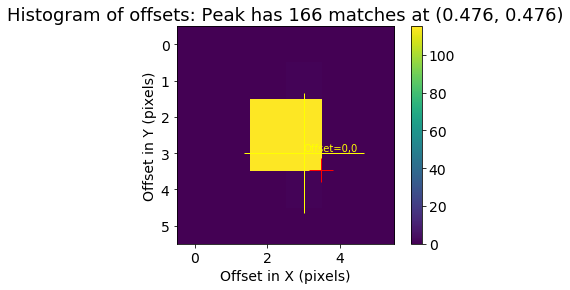

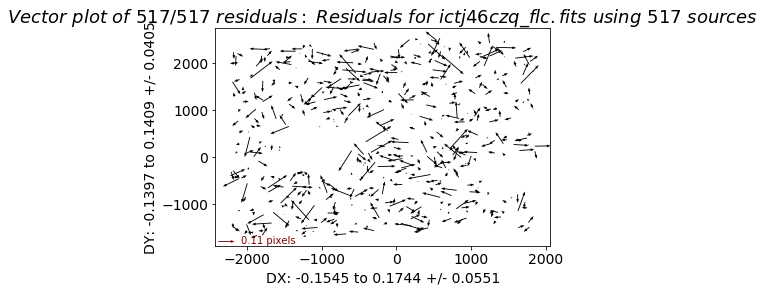

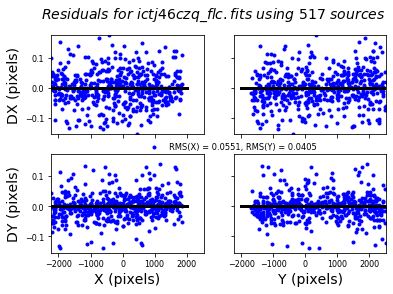

In [30]:
align_images(input_images, searchrad=.1, gaia=True, fluxcol=5, maxflux=-14., minflux=-11., fluxunits='mag')

#### Can look at shift file, saved as shifts.txt

The columns here are `xshift`, `yshift` (pixels), `rotation` (deg), `scale`, `xrms`, and `yrms`(pixels)

In [32]:
cat shifts.txt

# frame: output
# refimage: shifts_wcs.fits[wcs]
# form: delta
# units: pixels
ictj45ajq_flc.fits    0.001610  0.000232    359.999944     1.000002   0.051366  0.036729
ictj45b9q_flc.fits    -0.000896  0.006751    0.000079     1.000006   0.056577  0.038113
ictj46cuq_flc.fits    0.001214  0.002585    0.000135     1.000004   0.052337  0.033215
ictj46czq_flc.fits    0.005670  -0.000149    359.999986     1.000000   0.055086  0.040456


Aligning to gaia may result in slightly higher RMS values than aligning relatively (`gaia=False` and  `reference_catalog=None`) due to proper motions/inaccuracies in the gaia catalog.

In [ ]:
align_images(input_images, searchrad=.1, fluxcol=5, maxflux=-14., minflux=-11., fluxunits='mag')

In [ ]:
cat shifts.txt

# 3 Match/Average the catalogs into final catalog<a id="average"></a>

The final step takes the astrometrically corrected images/catalogs, and matches common stars between them, averaging those measurements into one final catalog as well as providing errors on each of those measurements, while clipping erroneous values.  It also flux calibrates (applies aperture, pixel area map, and zerpoint correction) the magnitudes, to make them ready for science!  This software also has the ability to produce a simple drizzled image of the input images, as to have a corresponding data file

### See options for final collation of the table

In [97]:
make_final_table?

In [33]:
tbl_i = make_final_table(input_images, min_detections=3)

/Users/vbajaj/Documents/wfc3_photometry/wfc3_photometry/photometry_tools/background_median.py:93: RuntimeWarning: invalid value encountered in true_divide
  values = cutout * mask.data / mask.data
/Users/vbajaj/Documents/wfc3_photometry/wfc3_photometry/photometry_tools/photometry_with_errors.py:126: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux)


Computed aperture correction of 0.09865528404331947           using 319 stars for ictj45ajq_flc_sci1_xyrd.cat
Computed aperture correction of 0.08428799362211681           using 332 stars for ictj45ajq_flc_sci2_xyrd.cat
Computed aperture correction of 0.07584681786562086           using 387 stars for ictj45b9q_flc_sci1_xyrd.cat
Computed aperture correction of 0.0694790911975165           using 405 stars for ictj45b9q_flc_sci2_xyrd.cat
Computed aperture correction of 0.04162598017525987           using 371 stars for ictj46cuq_flc_sci1_xyrd.cat
Computed aperture correction of 0.04860397302647801           using 389 stars for ictj46cuq_flc_sci2_xyrd.cat
Computed aperture correction of 0.04516534029910524           using 439 stars for ictj46czq_flc_sci1_xyrd.cat
Computed aperture correction of 0.05061409707354869           using 397 stars for ictj46czq_flc_sci2_xyrd.cat
Computing image coverage map.

Matching stars from input images with peaks in peakmap
N matched: 2770
N matched: 3138
N m

In [34]:
tbl_i

mbar,rbar,dbar,qbar,xbar,ybar,mstd,rstd,dstd,qstd,xstd,ystd,n,n_expected
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
24.012177830347287,201.55149750476403,-47.6161896317665,0.09033333333333333,437.59989455542706,1446.7922866755446,0.02352201851026551,2.1158525276210645e-07,2.8579993827411444e-07,0.031626290048347785,0.026517277105434618,0.01179661985093002,3,3
22.14263084066657,201.54459592217893,-47.6129865572328,0.04133333333333333,440.54023343925275,1960.0205030050765,0.024336795694171992,2.6202665302733095e-07,1.6941536322034702e-07,0.009568466729604883,0.008318722438813684,0.020624532515636132,3,3
23.637512379737387,201.5572201019916,-47.6189415953097,0.11599999999999999,442.36941444889794,1016.2637737566657,0.06500638084407713,5.318082993128053e-07,1.4594657077722714e-07,0.09807140255956372,0.015442390282454165,0.03159601198542837,3,3
21.658428903216684,201.55189854806943,-47.61647775327242,0.028333333333333335,445.0343070126626,1411.6711892523792,0.00573599378917262,2.5032126697372083e-07,1.8201020548598105e-07,0.00498887651569859,0.010380596060087757,0.02002061959955493,3,3
23.055830758072016,201.54509709080412,-47.61329650466678,0.074,446.09067358771307,1918.7320501277584,0.043314943106324014,7.940760855766866e-07,2.1563317228762682e-07,0.03965686153324122,0.026406397328741497,0.04530399774127755,3,3
22.410898136340617,201.54454061470008,-47.61304673075863,0.065,446.9629217373381,1959.6733498156989,0.05912959212691407,8.815967798685724e-08,5.560553683337124e-07,0.04270831300812525,0.038560289604252104,0.033091365675080246,3,3
24.056825697890094,201.54012096031542,-47.61096739793006,0.081,446.7802014847986,2289.8087486864865,0.0208646193291127,3.1783264121900093e-07,3.6084618638752984e-07,0.009416297927883692,0.023653899244651926,0.02990946139591769,3,3
23.215105690926446,201.5544936172299,-47.617740339975235,0.04533333333333334,448.284330137743,1215.6748465981411,0.007568308880750621,1.72417668209166e-07,2.221500255948527e-07,0.01391242450313947,0.012646460330393629,0.018948148596113466,3,3
22.77523693049425,201.53906584236304,-47.61050282335733,0.09166666666666667,449.1129204076521,2366.970294251761,0.032862272821875746,1.0184078344926471e-07,1.2616215406622018e-07,0.04793282336307298,0.01020057268168272,0.008141159326698554,3,3


# 4. See the results!<a id="results"></a>
The columns are mbar, rbar, dbar, qbar, xbar, and ybar which are mean magnitude (instrumental), RA, Dec, Q (fit quality), X position in the output frame, and Y position in the output frame.  The columns ending in 'std' are the standard deviations of the values.  The column 'n' is the number of times that source was detected (and not clipped out from the averaging).  The column `n_expected` is the number of images that covered that sky position, and thus the total number of times that star could have been detected by the input images.

### To access a column from the table, the syntax is `tbl[<colname>]` as seen below

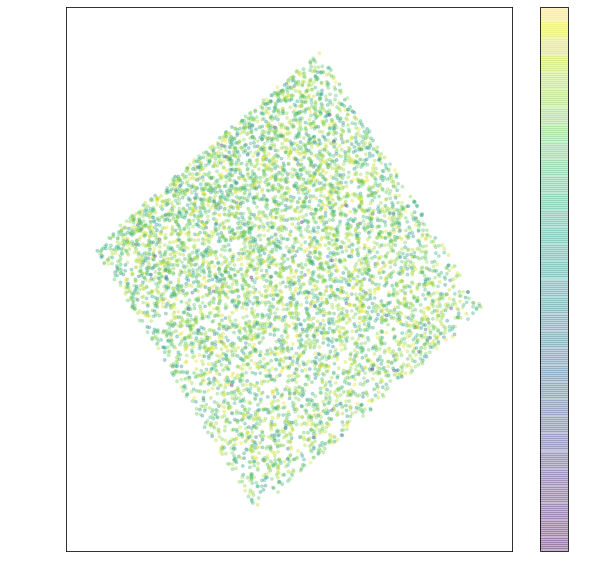

In [48]:
fig = plt.figure(figsize=(10,10))
plt.scatter(tbl_i['rbar'], tbl_i['dbar'], c=tbl_i['mbar'], s = 8, alpha=.3)
plt.xlim(plt.xlim()[::-1]) # reverse x axis for RA
plt.colorbar()

(-0.0, 0.1)

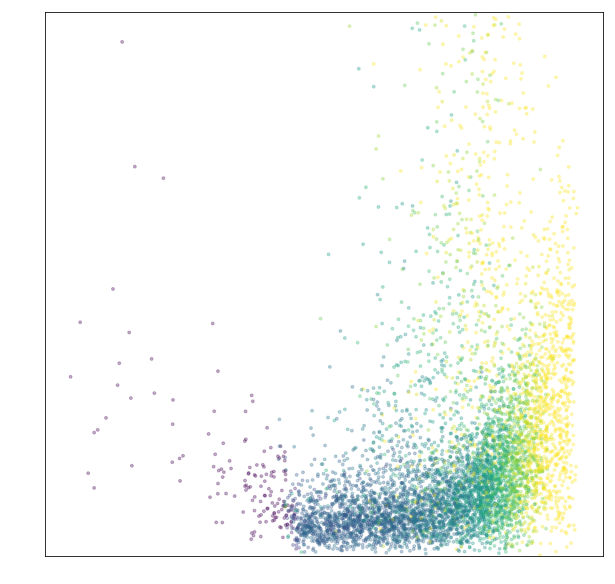

In [49]:
fig = plt.figure(figsize=(10,10))
plt.scatter(tbl_i['mbar'], tbl_i['mstd'], c=tbl_i['qbar'], s = 8, alpha=.3, vmin=0., vmax=.1, cmap='viridis')
plt.ylim(-.0,.1)

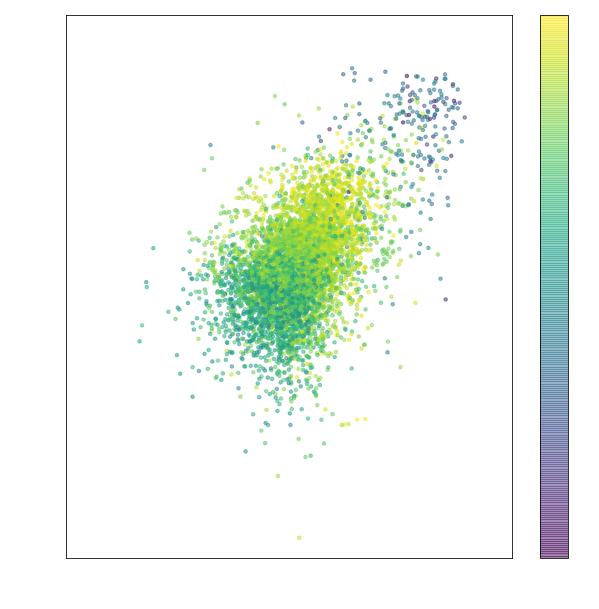

In [50]:
fig = plt.figure(figsize=(10,10))
plt.scatter(tbl_i['xstd'], tbl_i['ystd'], s = 12, alpha=.5, c=tbl_i['mbar'], cmap='viridis')
plt.xlim(0.0001, 1)
plt.ylim(0.0001, 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('xstd')
plt.ylabel('ystd')
plt.colorbar()

(19, 25)

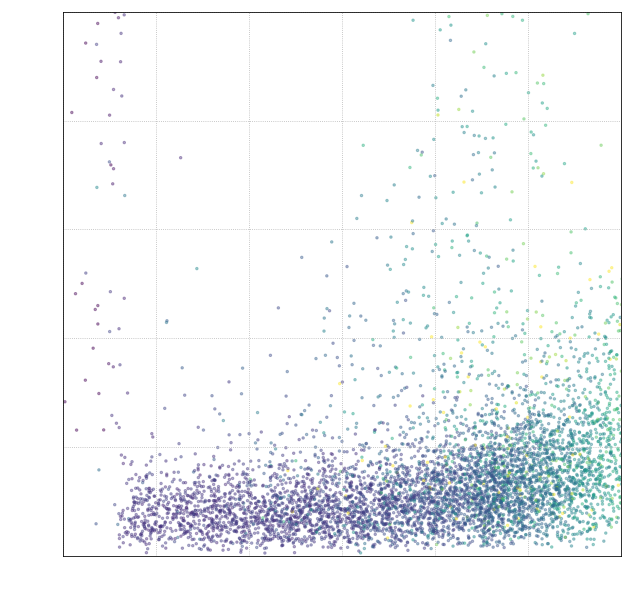

In [51]:
# stat, bedges, bn = binned_statistic(tbl['mbar'], tbl['xstd'],statistic=np.nanmedian, bins=20)
fig = plt.figure(figsize=(10,10))
plt.scatter(tbl_i['mbar'], tbl_i['xstd'], s=6, alpha=.4, c=tbl_i['qbar'], vmin=0, vmax=.2, cmap='viridis')

plt.xlabel('$\overline{m}$')
plt.ylabel('x std')
plt.grid(ls=':')
plt.ylim(-.0,.1)
plt.xlim(19, 25)

### Tables can be matched as well:

In [98]:
gaia_tbl = Table.read('gaia.cat', format='ascii.commented_header')
gaia_tbl['ra'].name = 'rbar'
gaia_tbl['dec'].name = 'dbar'
matched_i, matched_gaia = match_final_catalogs(tbl_i, gaia_tbl, max_distance=.04)

Text(0.5, 0, 'mbar')

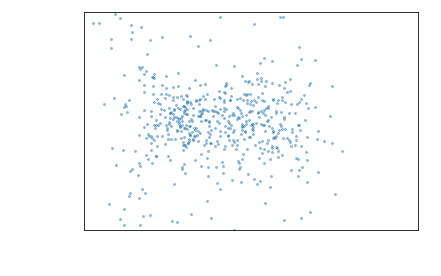

In [99]:
plt.scatter(matched_i['mbar'], (matched_i['rbar'] - matched_gaia['rbar'])*3600., s=4, alpha=.4)
plt.xlim(19., 22.)
plt.ylim(-.01, .01)
plt.ylabel('delta RA [arcsec]')
plt.xlabel('mbar')

Text(0.5, 0, 'mbar')

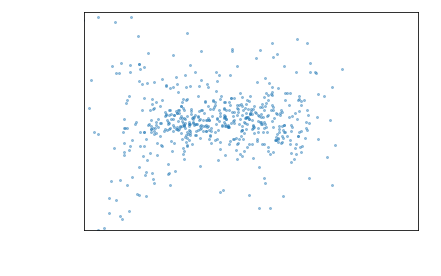

In [55]:
plt.scatter(matched_i['mbar'], (matched_i['dbar'] - matched_gaia['dbar'])*3600., s=4, alpha=.4)
plt.xlim(19., 22.)
plt.ylim(-.01, .01)
plt.ylabel('delta DEC [arcsec]')
plt.xlabel('mbar')

### Match tables from two filters

Run the same steps, with the F606W images to get an averaged catalog of those files.  Then we can match the F814W and F606W tables and make a simple CMD

In [ ]:
v_images =  [im for im in files if fits.getval(im, 'FILTER')=='F606W']
v_images =  [im for im in v_images if fits.getval(im, 'EXPTIME')>200]
run_hst1pass(v_images, hmin=hmin, fmin=fmin, pmax=pmax)
align_images(v_images, searchrad=1., gaia=True)
tbl_v = make_final_table(v_images, min_detections=3)

In [100]:
tbl_v = Table.read('F606W_final_cat.txt', format='ascii.commented_header')

In [101]:
matched_i, matched_v = match_final_catalogs(tbl_i, tbl_v)

(26, 16)

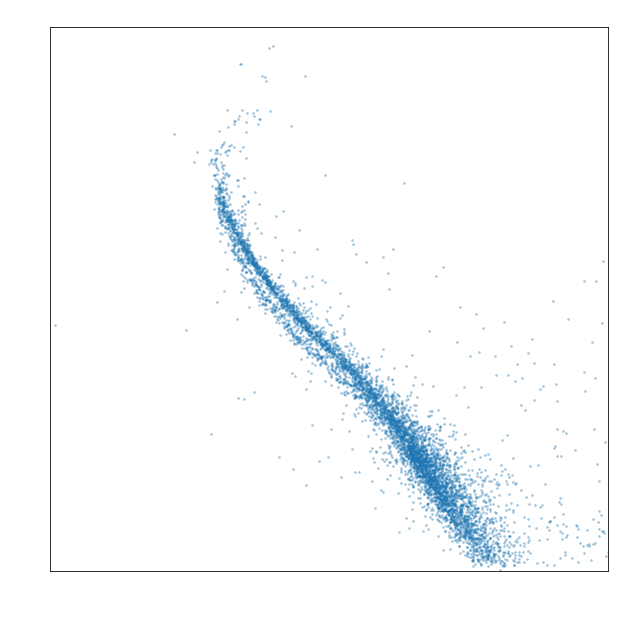

In [102]:
fig = plt.figure(figsize=(10,10))
plt.scatter(matched_v['mbar'] - matched_i['mbar'], matched_v['mbar'], s=3, alpha=.3)
plt.ylim(plt.ylim()[::-1])
plt.xlabel('V - I [mag]')
plt.ylabel('V [mag]')
plt.title('Color Magnitude Diagram')
plt.xlim(-1,1)
plt.ylim(26, 16)

# 4. Using models for other analysis
In addition to fitting stars in clusters, there are also tools for using the PSF models for addition/subtraction of stars

In [103]:
from psf_tools.PyFitting import subtract_psfs, make_models, get_subtrahend
from matplotlib.colors import LogNorm

In [66]:
data = fits.getdata('ictj45ajq_flc.fits')
mod1, mod2 = make_models('../psf_tools/PSFSTD_WFC3UV_F814W.fits')
cat = Table.read('ictj45ajq_flc_sci1_xyrd.cat', format='ascii.commented_header')
subbed = subtract_psfs(data, cat, mod1)

(0, 500)

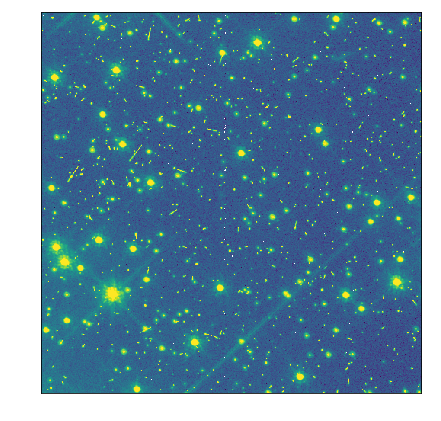

In [89]:
plt.figure(figsize=(15,7))
plt.imshow(data, vmin=12, vmax=1100, norm=LogNorm(), origin='lower')
plt.xlim(0, 500)
plt.ylim(0, 500)

(0, 500)

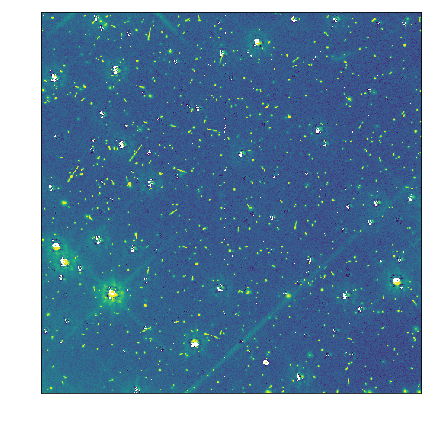

In [90]:
plt.figure(figsize=(15,7))
plt.imshow(subbed, vmin=12, vmax=1100, norm=LogNorm(), origin='lower')
plt.xlim(0, 500)
plt.ylim(0, 500)

(0, 500)

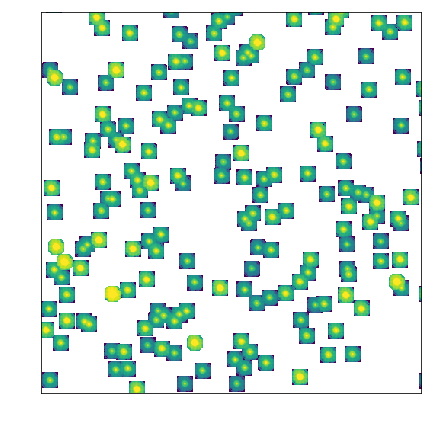

In [114]:
fluxes = np.power(10, cat['m']/-2.5).data
# subtrahend = get_subtrahend(cat['x'], cat['y'], fluxes, mod1, data.shape)
plt.figure(figsize=(15,7))
plt.imshow(np.abs(subtrahend), vmin=.001, vmax=1100, norm=LogNorm(), origin='lower')
plt.xlim(0, 500)
plt.ylim(0, 500)